In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

## Data cleaning

In [ ]:
df = pd.read_csv('./cardio_train.csv', sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
df.isnull().values.any()

False

In [ ]:
df.drop(columns=['id'], inplace=True)

In [ ]:
df.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [ ]:
continuous_features = [feature for feature in df.columns if len(df[feature].unique())>25]
print('Continuous Values are : {}'.format(continuous_features))

Continuous Values are : ['age', 'height', 'weight', 'ap_hi', 'ap_lo']


In [ ]:
categorical_features = [feature for feature in df.columns if feature not in continuous_features]

df[categorical_features]=df[categorical_features].astype("category")

In [ ]:
#change categorical features to have right dtype
df.dtypes

age               int64
gender         category
height            int64
weight          float64
ap_hi             int64
ap_lo             int64
cholesterol    category
gluc           category
smoke          category
alco           category
active         category
cardio         category
dtype: object

In [ ]:
print("continuous var: " , continuous_features)
print("categorical var: " , categorical_features)

continuous var:  ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical var:  ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [ ]:
df.cardio.value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

Percentage of patient had a HeartDisease:  49.97 %  --> (34979 patient)
Percentage of patient did not have a HeartDisease: 50.03  %  --> (35021 patient)


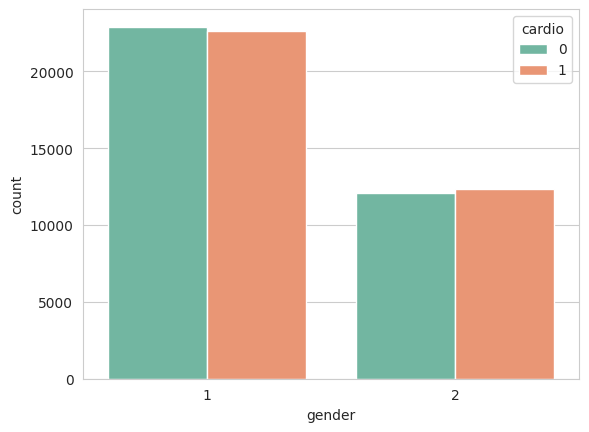

In [ ]:
y = df['cardio']
print(f'Percentage of patient had a HeartDisease:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')

sb.set_style('whitegrid')
sb.countplot(x=df.gender,hue=df.cardio, palette="Set2");

#dataset is balanced

In [ ]:
df.corr()

<ipython-input-14-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,height,weight,ap_hi,ap_lo
age,1.000000,-0.081515,0.053684,0.020764,0.017647
height,-0.081515,1.000000,0.290968,0.005488,0.006150
weight,0.053684,0.290968,1.000000,0.030702,0.043710
ap_hi,0.020764,0.005488,0.030702,1.000000,0.016086
ap_lo,0.017647,0.006150,0.043710,0.016086,1.000000


<ipython-input-15-02b21e07640e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", annot_kws = {"size": 12})


<Axes: >

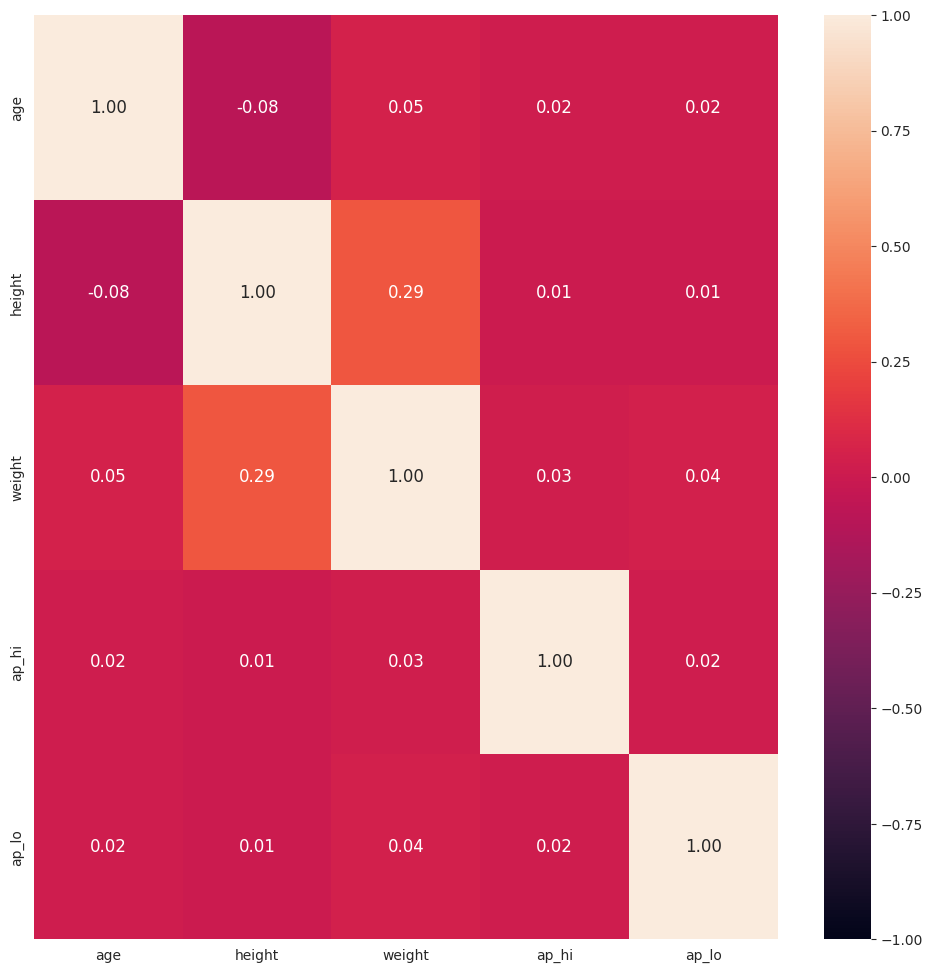

In [ ]:
#heatmap of correlation matrix
f = plt.figure(figsize=(12, 12))
sb.heatmap(df.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", annot_kws = {"size": 12})

#only height and weight are slightly correlated features.

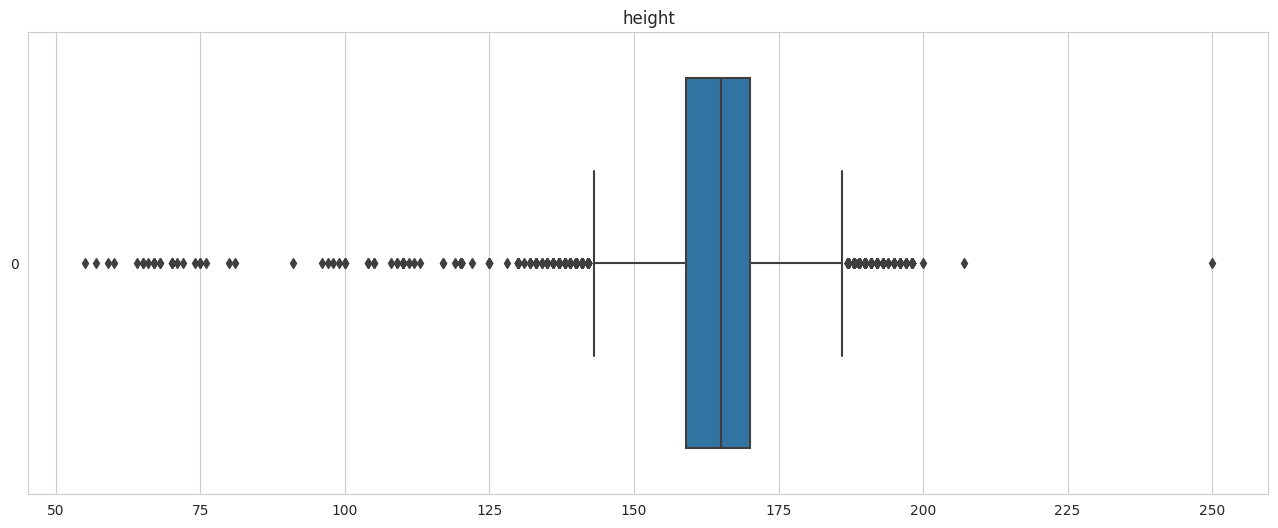

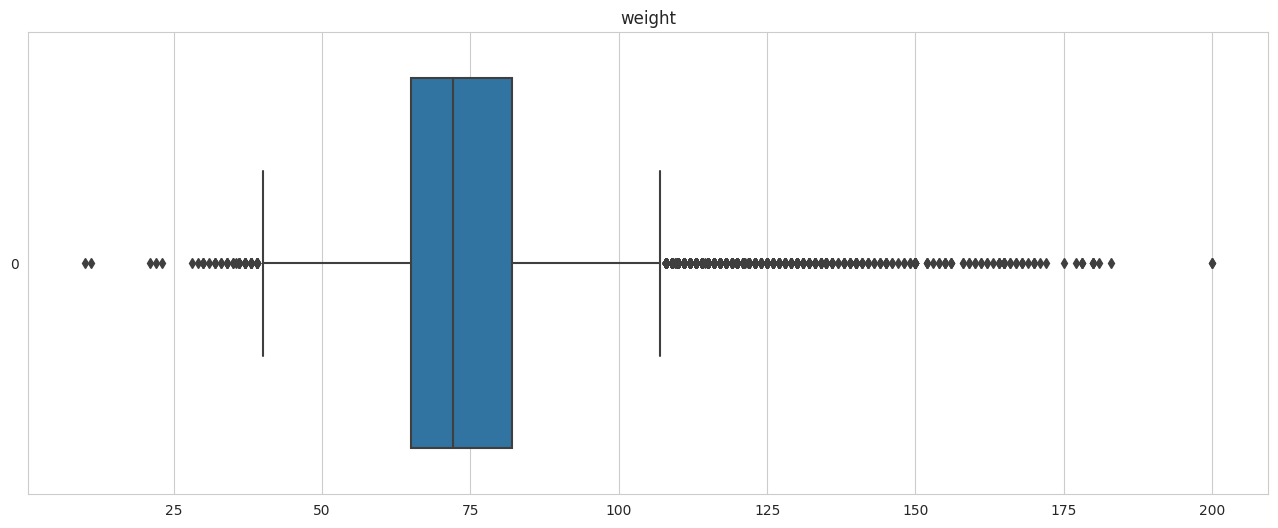

In [ ]:
for i,var in enumerate(['height', 'weight']):
    plt.figure(i,figsize=(16, 6))
    sb.boxplot(df[var], orient='h').set(title=var)
    
#there are many outliers for height and weight above Q3+1.5IQR and below Q1-1.5IQR

In [ ]:
df.describe()

#min height = 55, max height = 250
#min weight = 10, max weight = 200

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414
std,2467.251667,8.210126,14.395757,154.011419,188.472530
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


In [ ]:
cleaned_df = df
cleaned_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
#remove outliers above upper fence and below lower fence
for feature in ['height','weight']:
        Q1 = np.percentile(df[feature], 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(df[feature], 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 
        upper_fence = Q3 + outlier_step
        lower_fence = Q1 - outlier_step
        outliers = df[feature][~((df[feature] >= lower_fence) & (df[feature] <= upper_fence))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(feature, len(outliers)))
        cleaned_df = cleaned_df[~((cleaned_df[feature] < lower_fence) | (cleaned_df[feature]> upper_fence))]

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [ ]:
cleaned_df.describe()

#new min height = 143, new max height = 186
#new min weight = 40, new max weight = 107

,age,height,weight,ap_hi,ap_lo
count,67723.000000,67723.000000,67723.000000,67723.000000,67723.000000
mean,19468.502163,164.310013,73.059601,128.585001,95.993030
std,2468.007310,7.565537,12.407575,156.523767,189.111316
min,10798.000000,143.000000,40.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21324.000000,170.000000,81.000000,140.000000,90.000000
max,23713.000000,186.000000,107.000000,16020.000000,11000.000000


In [ ]:
#remove ap_hi and ap_lo values that are negative
cleaned_df = cleaned_df[cleaned_df['ap_lo']>=0]
cleaned_df = cleaned_df[cleaned_df['ap_hi']>=0]

In [ ]:
#remove rows where ap_hi < ap_lo
print('There are {} observations where ap_hi < ap_lo'.format(len(cleaned_df[cleaned_df['ap_hi'] < cleaned_df['ap_lo']])))
cleaned_df = cleaned_df[cleaned_df['ap_hi'] >= cleaned_df['ap_lo']].reset_index(drop=True)

There are 1143 observations where ap_hi < ap_lo


In [ ]:
#check for rows where ap_hi > 350
(cleaned_df['ap_hi']>350).sum()


39

In [ ]:
#remove rows where ap_hi < 20
(cleaned_df['ap_hi']<20).sum()

3

In [ ]:
cleaned_df= cleaned_df[(cleaned_df['ap_lo']<350) & (cleaned_df['ap_hi']<350)].copy()
cleaned_df= cleaned_df[(cleaned_df['ap_lo']>20) & (cleaned_df['ap_hi']>20)].copy()

In [ ]:
print('Total observations preserved : {}'.format(len(cleaned_df)))

Total observations preserved : 66489


In [ ]:
cleaned_df.shape

(66489, 12)

## Baseline Error rate

In [ ]:
cleaned_df.cardio.value_counts()

0    33927
1    32562
Name: cardio, dtype: int64

In [ ]:
#baseline error rate
print("Baseline error rate is: ", round(1- (33927/ (33927+32562)),6))

Baseline error rate is:  0.489735


## Feature engineering

In [ ]:
#create BMI column
cleaned_df["BMI"] = round(cleaned_df["weight"] / (cleaned_df["height"]/100)**2,3)

In [ ]:
#create MAP column
#MAP = DP + 1/3(SP – DP)
cleaned_df["MAP"] = round(cleaned_df['ap_lo'] + ((cleaned_df['ap_hi']-cleaned_df['ap_lo'])/3),3)

In [ ]:
# assign features and target
X = cleaned_df.drop('cardio',axis=1)
y = cleaned_df['cardio']

In [ ]:
# one hot encode categorical features for feature engineering
X = pd.get_dummies(X)
X.head(3)

,age,height,weight,ap_hi,ap_lo,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
0,18393,168,62.0,110,80,0,1,1,0,0,1,0,0,1,0,1,0,0,1
1,20228,156,85.0,140,90,1,0,0,0,1,1,0,0,1,0,1,0,0,1
2,18857,165,64.0,130,70,1,0,0,0,1,1,0,0,1,0,1,0,1,0


In [ ]:
#feat eng on training set
poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
Xe = poly.fit_transform(X)
cols = poly.get_feature_names_out(X.columns)
Xe = pd.DataFrame(Xe, columns=cols)

In [ ]:
# export engineered features
Xe.to_csv("./X.csv", index=False)
y.to_csv("./y.csv", index=False)

In [ ]:
# perform feature engineering with standardized features
Xs = cleaned_df.drop('cardio',axis=1)
ys = cleaned_df['cardio']

In [ ]:
# Perform standardization and one-hot-encoding
Xs_num = Xs.select_dtypes(include='number')
Xs_cat = Xs.select_dtypes(exclude='number')
Xs_num = (Xs_num - Xs_num.mean())/Xs_num.std()
Xs_cat = pd.get_dummies(Xs_cat)
Xs = pd.concat([Xs_num, Xs_cat], axis=1)
Xs.head(3)

,age,height,weight,ap_hi,ap_lo,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
0,-0.433788,0.488110,-0.888124,-0.992845,-0.124219,0,1,1,0,0,1,0,0,1,0,1,0,0,1
1,0.309455,-1.100511,0.969301,0.825095,0.941111,1,0,0,0,1,1,0,0,1,0,1,0,0,1
2,-0.245851,0.090955,-0.726609,0.219115,-1.189548,1,0,0,0,1,1,0,0,1,0,1,0,1,0


In [ ]:
#feat eng on standardized set
poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
Xse = poly.fit_transform(Xs)
cols = poly.get_feature_names_out(Xs.columns)
Xse = pd.DataFrame(Xse, columns=cols)

In [ ]:
# export engineered features
Xse.to_csv("./X-standardized.csv", index=False)
y.to_csv("./y.csv", index=False)

## Feature selection

<ipython-input-35-f3e296c1cbff>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(cleaned_df.corr(), annot = True, linewidths=.5, cmap="YlGnBu")


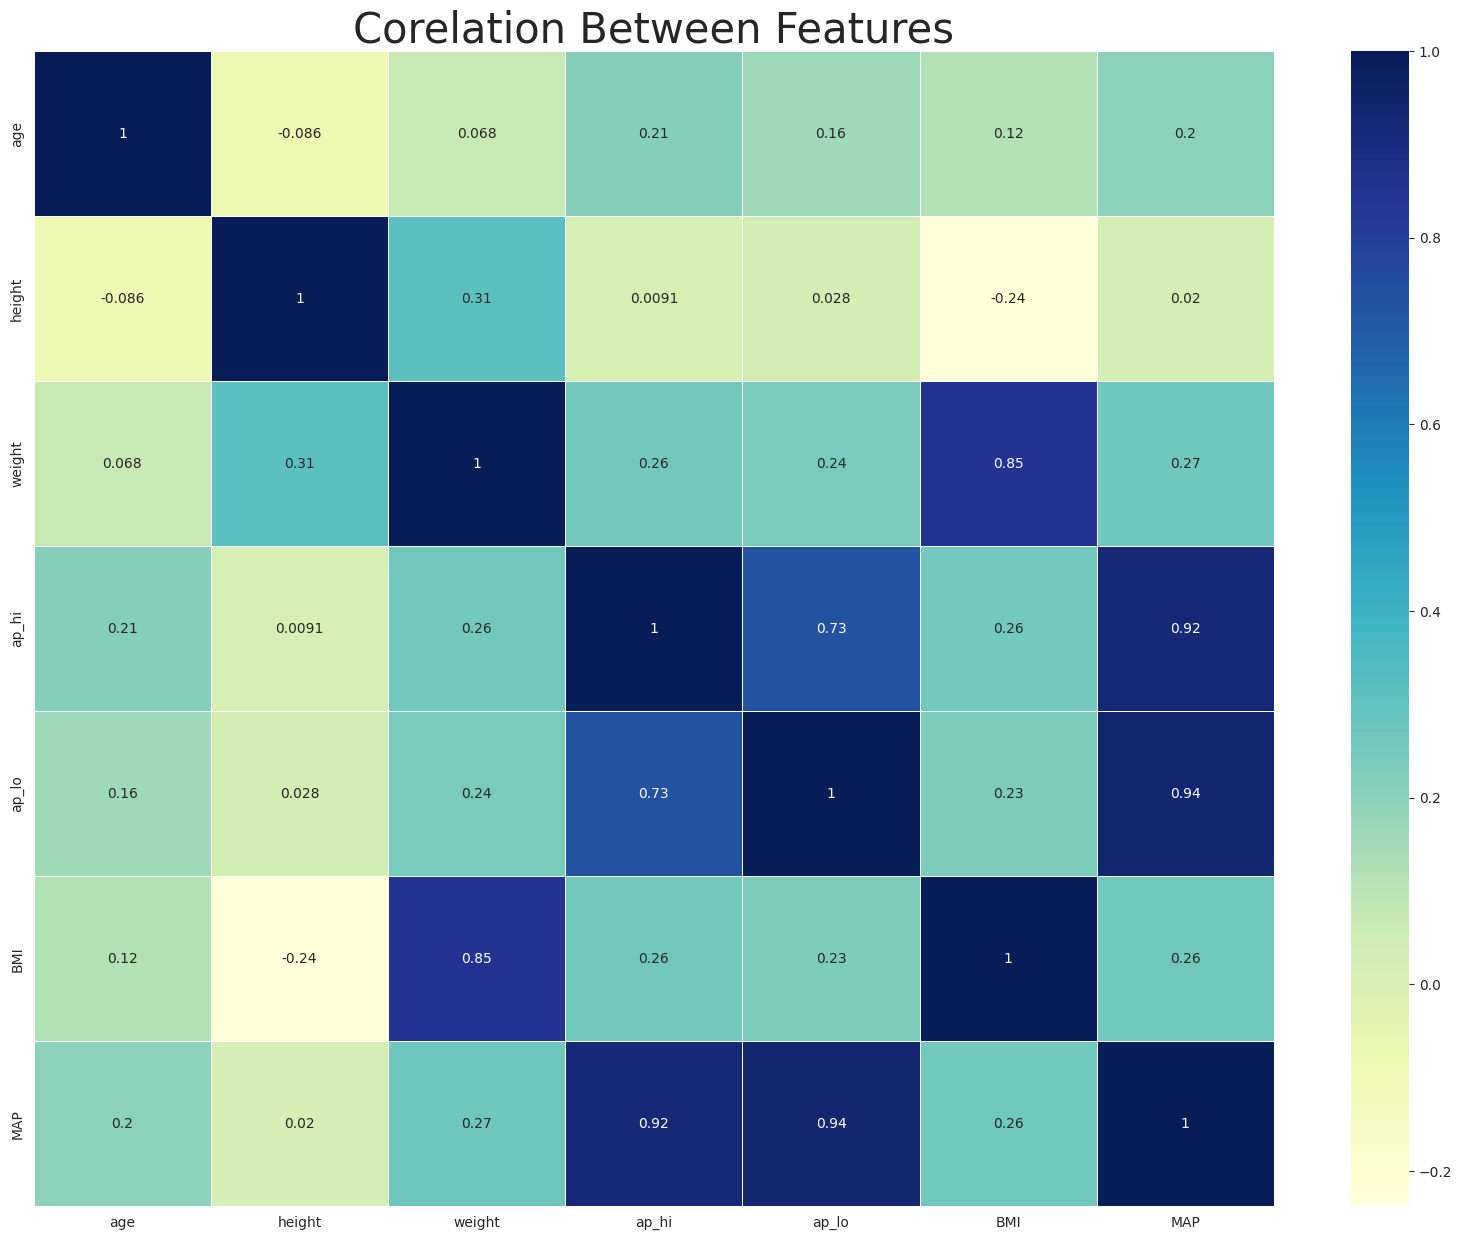

In [ ]:
plt.rcParams['figure.figsize'] = (20, 15) 
sb.heatmap(cleaned_df.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

#since MAP is highly correlated with ap_hi (0.99), we may remove MAP

In [ ]:
Xe['bias'] = 1

In [ ]:
def SelectFeatures(model, candidates, X, y):
        N = len(candidates)
        R2 = np.zeros(N)
        for k in range(N):
            model_k = model.copy()
            model_k.append(candidates[k])
            cv_results = cross_validate(lr, X[model_k], y, n_jobs = -1)
            R2[k] = cv_results['test_score'].mean()
        R2_max = R2.max()
        selected = candidates[R2.argmax()]
        return (selected, R2_max)

In [ ]:
Xe.dtypes

age                  float64
height               float64
weight               float64
ap_hi                float64
ap_lo                float64
                      ...   
alco_1 active_1      float64
active_0^2           float64
active_0 active_1    float64
active_1^2           float64
bias                   int64
Length: 210, dtype: object

In [ ]:
model =['bias']
candidates = list(Xe.columns)
candidates.remove('bias')

R2 = []
lr = LogisticRegression(fit_intercept=False)
cv_results = cross_validate(lr, Xe[model].values.reshape(-1,1), y)
R2.append(cv_results['test_score'].mean())

while (len(candidates) > 0):
    print('Candidates left: ', len(candidates), end='   ')
    (selected, R2_max) = SelectFeatures(model, candidates, Xe, y)
    candidates.remove(selected)
    model.append(selected)
    R2.append(R2_max)
    print('selected: ', selected)

results = pd.DataFrame()
results['feature added'] = model
results['validation R2'] = R2

ix = results['validation R2'].idxmax()
print()
print('use features 0 to ', ix, end='       ')
R2_max = results['validation R2'].max()
print('max validation R2 = ', round(R2_max, 3))
model_opt = model[0:ix+1]

Candidates left:  209   selected:  ap_hi
Candidates left:  208   selected:  cholesterol_3
Candidates left:  207   selected:  smoke_0 alco_0
Candidates left:  206   selected:  cholesterol_3 gluc_3
Candidates left:  205   selected:  gender_2 gluc_3
Candidates left:  204   selected:  ap_lo active_1
Candidates left:  203   selected:  gender_1 gender_2
Candidates left:  202   selected:  ap_lo gender_1
Candidates left:  201   selected:  gluc_2 alco_0
Candidates left:  200   selected:  ap_hi alco_0
Candidates left:  199   selected:  ap_hi gluc_3
Candidates left:  198   selected:  gluc_2 smoke_1
Candidates left:  197   selected:  cholesterol_3 active_0
Candidates left:  196   selected:  cholesterol_3 smoke_1
Candidates left:  195   selected:  cholesterol_1 cholesterol_2
Candidates left:  194   selected:  cholesterol_1 cholesterol_3
Candidates left:  193   selected:  cholesterol_2 cholesterol_3
Candidates left:  192   selected:  gluc_1 gluc_2
Candidates left:  191   selected:  gluc_1 gluc_3
Can

In [ ]:
model_opt

['bias',
 'age ap_lo',
 'ap_lo BMI',
 'ap_lo^2',
 'age^2',
 'height BMI',
 'ap_lo',
 'height ap_lo',
 'height MAP',
 'height ap_hi',
 'MAP^2',
 'age',
 'age weight',
 'height',
 'weight BMI',
 'height^2',
 'age height',
 'weight^2',
 'height weight',
 'BMI',
 'weight',
 'age BMI',
 'weight ap_lo',
 'BMI^2',
 'age MAP',
 'age ap_hi']